1. Load a word embedding model using the genism API.
Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. 

In [ ]:
#!pip install --upgrade gensim
import gensim.downloader as api

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


2. Create the Query object using the target words (male names and female names) and two attribute words sets (Career and Family terms) # modify later

In [ ]:
#target sets (Male/Female names)
male_names = ['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']
female_names = ['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']

#attribute sets (Career/Family titles)
career = ['executive', 'management', 'professional', 'corporation',
         'salary', 'office', 'business', 'career']
family = ['home', 'parents', 'children', 'family', 'cousins', 'marriage',
         'wedding', 'relatives']

#query (T1, T2, A1, A2) order is not important
gender_occupation_query = Query([male_names, female_names],
                                [career, family],
                                ['Male names', 'Female names'],
                                ['Career', 'Family'])
                      

In [ ]:
import os
import json
import argparse # parser for command-line options, arguments and sub-commands


def main(args):
    weat_dict = dict()

    # build weat_dict
    for data_name in os.listdir(args.weat_dir):
        path = os.path.join(args.weat_dir, data_name)

        if os.path.abspath(path) == os.path.abspath(args.output):
            continue

        data_dict = dict()
        weat_dict[data_name] = data_dict
        keys = []

        with open(path) as f:
            for line in f.readlines():
                if not line.strip():
                    continue

                key, values = line.split(':')
                key = key.strip()
                values = [w.strip().lower() for w in values.split(',')]

                data_dict[key] = values
                keys.append(key)

        if len(keys) == 3:
            data_dict['method'] = 'wefat'

            data_dict['W_key'] = keys[0]
            data_dict['A_key'] = keys[1]
            data_dict['B_key'] = keys[2]

            data_dict['targets'] = '{}'.format(keys[0])
            data_dict['attributes'] = '{} vs {}'.format(keys[1], keys[2])

        elif len(keys) == 4:
            data_dict['method'] = 'weat'

            data_dict['X_key'] = keys[0]
            data_dict['Y_key'] = keys[1]
            data_dict['A_key'] = keys[2]
            data_dict['B_key'] = keys[3]

            data_dict['targets'] = '{} vs {}'.format(keys[0], keys[1])
            data_dict['attributes'] = '{} vs {}'.format(keys[2], keys[3])

    with open(args.output, 'w') as f:
        json.dump(weat_dict, f, sort_keys=True, indent=4)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weat_dir', type=str, default='weat/', required=True,
                        help='WEAT data directory')
    parser.add_argument('--output', type=str, default='weat.json', required=True,
                        help='Output JSON file path')

    args = parser.parse_args()
    main(args)

In [ ]:
import math
import numpy as np

def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))


def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return numerator/float(denominator)

def weat_association(W, A1, A2):
    """
    Returns association of the word w in W with the attribute for WEAT score. 
    param W: target words' vecotr representations
    param A1, A2: attribute words' vector representations
    return: (len(W), ) shaped numpy ndarray. each rows represet association of the word w in W
    """
    return np.mean(cosine_similarity(W, A), axis=-1) - np.mean(cosine_similarity(W, A2), axis=-1)

def weat_score(X, Y, A, B):
    """
    Returns WEAT score
    X, Y, A, B must be (len(words), dim) shaped numpy ndarray
    CAUTION: this function assumes that there's no intersection word between X and Y
    :param X: target words' vector representations
    :param Y: target words' vector representations
    :param A: attribute words' vector representations
    :param B: attribute words' vector representations
    :return: WEAT score
    """
    x_association = weat_association(X, A, B)
    y_association = weat_association(Y, A, B)

    tmp1 = np.mean(x_association, axis=-1) - np.mean(y_association, axis=-1)
    tmp2 = np.std(np.concatenate((x_association, y_association), axis=0))

    return tmp1 / tmp2


Bias Calculator

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.1 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 636 kB 64.5 MB/s 
     |████████████████████████████████| 895 kB 60.3 MB/s 
     |████████████████████████████████| 3.3 MB 54.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import torch

def softmax(arr, axis=1): #calculating the scores which allows the higher correlation of the hidden state to have a larger fractional value. 
  e = np.exp(arr)
  return e / e.sum(axis=axis, keepdims=True)





---








# **0. Preprocessing** 

In [2]:
!pip install transformers

In [3]:
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModelWithLMHead, pipeline #what is the difference between this model with the others?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #bert-base-uncased: This model is not case-sensitive: it doesn't make a difference between english and English.
model = AutoModelWithLMHead.from_pretrained("bert-base-uncased") 


/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:664: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationshi

# **1. Bias Score**

In [82]:
# Prepare a template sentence
"He is a programmer."
"[Target] is a [Attribute]."

# Replace Target word with [MASK] and compute the probability that BERT assigns "he" for the target word.
sentence = f"{tokenizer.mask_token} is a programmer."

input_ids = tokenizer.encode(sentence, return_tensors='pt') 
#return_tensors = 'pt' is for the tokenizer to return PyTorch tensors. (if you don't, it returns to a list)
#a tokenzied representation of our text > a labels tensor to calculate loss against. example output: tensor([[ 101, 2002, 2003, 1037,  103, 1012,  102]])
mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

token_logits = model(input_ids)[0] #get a tensor of logits
mask_token_logits = token_logits[0, mask_token_index, :] # what is this for?
mask_token_logits = torch.softmax(mask_token_logits, dim=1) #to get probability, apply softmax on the logits

'''
top_5 = torch.topk(mask_token_logits, 5, dim=1)
top_5_tokens = zip(top_5.indices[0].tolist(), top_5.values[0].tolist())

for token, score in top_5_tokens:
  print(sentence.replace(tokenizer.mask_token, tokenizer.decode([token])), f"(score: {score})")
'''

# Get the probability of token_id
target_word = 'he'
target_word_id = tokenizer.encode(target_word, add_special_tokens=False)[0] 


token_prob = mask_token_logits[:, target_word_id].detach().numpy()[0] # extract the prob from tensor (convert into numpy)
what_is_this = mask_token_logits[:, target_word_id].detach().numpy()
print(what_is_this.shape[0]) 
#print(token_prob)

#print(f"Probability of {target_word}: {mask_token_logits[:, target_word_id]}")

# Replace both Target word and Attribute word with [MASK] and compute the probability. 

sentence_masked = f"{tokenizer.mask_token} is a {tokenizer.mask_token}."


1


In [ ]:
#error occures with EEC dataset [error] index 0 is out of bounds for axis 0 with size 0
sentence = f"{tokenizer.mask_token} is a {tokenizer.mask_token}."
input_ids = tokenizer.encode(sentence, return_tensors='pt') #a tokenzied representation of our text > a labels tensor to calculate loss against. example output: tensor([[ 101, 2002, 2003, 1037,  103, 1012,  102]])
#print(input_ids)
#print(tokenizer.mask_token_id) # mask_token_id: a special token representing a masked token. 103 always? yes
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1] # 1 is correct. output: tensor[0], tensor[4]
token_logits = model(input_ids)[0] #get a tensor of logits
token_logits = model(input_ids)
token_logits[0]
#mask_token_logits = token_logits[0, mask_token_index, :]
#input_ids
#torch.where(input_ids == tokenizer.mask_token_id)[1]


tensor([[[ -6.2547,  -6.2237,  -6.2335,  ...,  -5.6797,  -5.3782,  -3.6820],
         [ -5.7224,  -5.8551,  -5.7565,  ...,  -6.1741,  -5.7089,  -3.6054],
         [ -8.6220,  -9.1370,  -8.5651,  ...,  -8.4831,  -6.4301,  -5.6664],
         ...,
         [ -1.7054,  -1.9459,  -1.8709,  ...,  -2.4591,  -3.8057,  -4.2187],
         [-12.4419, -11.7795, -12.4005,  ..., -10.0734, -11.2097,  -7.6816],
         [ -7.7706,  -7.6850,  -7.7349,  ...,  -7.1374,  -6.8456,  -4.5346]]],
       grad_fn=<AddBackward0>)

In [4]:
def get_prob(sentence, target_word):
  input_ids = tokenizer.encode(sentence, return_tensors='pt')
  mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1] #mask's position 0 or 1?

  token_logits = model(input_ids)[0]
  mask_token_logits = token_logits[0, mask_token_index, :] #get the logits
  mask_token_logits = torch.softmax(mask_token_logits, dim=1) #to get probability, apply softmax on the logits

  target_word_id = tokenizer.encode(target_word, add_special_tokens=False)[0]
  token_prob = mask_token_logits[:, target_word_id].detach().numpy()[0] #sometimes get an error "index 0 is out of bounds for axis 0 with size 0" which means that I don't have the inex I'm trying to reference.
  ##solved with try/except block?

  return token_prob


def score(sentence, sentence_masked, target_word):
  prob = get_prob(sentence, target_word)
  prior_prob = get_prob(sentence_masked, target_word)
  association = np.log(prob/prior_prob)

  return association

In [ ]:

input_ids = tokenizer.encode(sentence, return_tensors='pt')
mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)

In [5]:
#gender
sample_sentence = f"{tokenizer.mask_token} is a programmer"
sample_sentence_masked = f"{tokenizer.mask_token} is a {tokenizer.mask_token}."
sample_mw = "he"
sample_fw = "she"
#prob(sample_sentence, sample_mw)

In [6]:
#get_prob(sample_sentence_masked, sample_fw)
score(sample_sentence, sample_sentence_masked, sample_fw)

-0.08490357

In [7]:
#race
sample_sentence = f"{tokenizer.mask_token} is happy."
sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."
sample_aw = "Brad"
sample_afw = "Hakim"

In [8]:
print("Target probability:",get_prob(sample_sentence, sample_aw))
print("Attribute prior probability:", get_prob(sample_sentence_masked, sample_aw))


Target probability: 0.0005264802
Attribute prior probability: 0.00020677218


# **2. Data** 



##2.1  An Implicit Association Test (IAT) data 


In [5]:
#Target Words
Japanese_names = ["Hitaka", "Yokomichi", "Fukamachi", "Yamamoto", "Itsumatsu", "Yagimoto", "Kawabashi", "Tsukimoto", "Kushibashi", "Tanaka", "Kuzumaki", "Takasawa", "Fujimoto", "Sugimoto", "Fukuyama", "Samukawa", "Harashima", "Sakata", "Kamakura", "Namikawa", "Kitayama", "Nakamoto", "Minakami", "Morimoto", "Miyamatsu"]
Korean_names = ["Hwang", "Hyun", "Choung", "Maeng", "Chun", "Choe", "Kwon", "Sunwoo", "Whang", "Byun", "Sohn", "Kung", "Youn", "Chae", "Choi", "Chon", "Kwan", "Jung", "Kang", "Hwangbo", "Bhak", "Paik", "Chong", "Jang", "Yoon"]
Truncated_Japanese_names = ["Hitak", "Yoko", "Fukama", "Yamam", "Itsu", "Yagi", "Kawa", "Tsukim", "Kushi", "Tana", "Kuzu", "Taka", "Fuji", "Sugi", "Fuku", "Samu", "Hara", "Saka", "Kama", "Namikaw", "Kita", "Naka", "Minak", "Mori", "Miya"]
White_American_male_names = ["Adam", "Chip", "Harry", "Josh", "Roger", "Alan", "Frank", "Ian", "Justin", "Ryan", "Andrew", "Fred", "Jack", "Matthew", "Stephen", "Brad", "Greg", "Jed", "Paul", "Todd", "Brandon", "Hank", "Jonathan", "Peter", "Wilbur"]
Black_American_male_names = ["Alonzo", "Jamel", "Lerone", "Percell", "Theo", "Alphonse", "Jerome", "Leroy", "Rasaan", "Torrance", "Darnell", "Lamar", "Lionel", "Rashaun", "Tyree", "Deion", "Lamont", "Malik", "Terrence", "Tyrone", "Everol", "Lavon", "Marcellus", "Terryl", "Wardell"]
White_American_female_names = ["Amanda", "Courtney", "Heather", "Melanie", "Sara", "Amber", "Crystal", "Katie", "Meredith", "Shannon", "Betsy", "Donna", "Kristin", "Nancy", "Stephanie", "Bobbie-Sue", "Ellen", "Lauren", "Peggy", "Sue-Ellen", "Colleen", "Emily", "Megan", "Rachel", "Wendy"]
Black_American_female_names = ["Aiesha", "Lashelle", "Nichelle", "Shereen", "Temeka", "Ebony", "Latisha", "Shaniqua", "Tameisha", "Teretha", "Jasmine", "Latonya", "Shanise", "Tanisha", "Tia", "Lakisha", "Latoya", "Sharise", "Tashika", "Yolanda", "Lashandra", "Malika", "Shavonn", "Tawanda", "Yvette"]
Black_names = Black_American_male_names + Black_American_female_names 
White_names = White_American_male_names + White_American_female_names #50

#Attribute Words
Good_words = ["Honest", "Joy", "Love", "Peace", "Wonderful", "Honor", "Pleasure", "Glorious", "Laughter", "Happy"]
Bad_words = ["Agony", "Prison", "Terrible", "Horrible", "Nasty", "Evil", "Awful", "Failure", "Hurt", "Poverty"]

In [14]:
sample_sentence = f"{tokenizer.mask_token} is happy."
sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."
#sample_sentence = f"‘The conversation with {tokenizer.mask_token} was horrible."
#sample_sentence_masked = f"The conversation with {tokenizer.mask_token} was {tokenizer.mask_token}."

In [ ]:
#score(sample_sentence, sample_sentence_masked, sample_mw)
score(sample_sentence, sample_sentence_masked, 'her')

1.3227628

In [11]:
print("White American:", score(sample_sentence, sample_sentence_masked, "Adam"))
print("Japanese:", score(sample_sentence, sample_sentence_masked, "Hitaka"))
print("Korean:", score(sample_sentence, sample_sentence_masked, "Hwang"))
print("Black American:", score(sample_sentence, sample_sentence_masked, "Alonzo"))

White American: -0.054676913
Japanese: 0.12985544
Korean: -0.62839705
Black American: -0.77253926


#**3. Plotting**

3.1 create four lists (white american, korean, japanese, black american) of scores with the attribute "happy"


In [30]:
# create a list of scores with the attribute "happy"
#data = {'white_american': [a for a in White_names], 'emotion word': [a for a in emotion_words]}
def get_list(name_list, attribute_word):
  sample_sentence = f"{tokenizer.mask_token} is happy."
  sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."
  score_list = []
  for name in name_list:
    score_list.append(score(sample_sentence, sample_sentence_masked, name))
    
  return score_list
#output: [0.7557069, 0.10728561, 0.8170987, 0.9986831, 1.1286151, 0.6211711, 1.0266936, 1.1127487, 0.47095704, 1.3455651, 1.2774255, 0.88605505, 0.9592774, 0.23234563, 0.35004058, 0.9345962, 0.8906533, 0.6567374, 0.76856726, 0.06865844, 0.87254965, 0.76424813, 0.29678065, 0.33684844, 1.3196832, 0.57769644, 0.7553741, 1.0121622, 1.8641241, 1.2491404, 1.3822653, 0.67383295, 0.99662566, 0.79990786, 1.1835644, 1.4027702, 2.20842, 1.1761029, 1.2255155, 1.1497813, 0.8250324, 1.486984, 0.97088486, 1.2103407, 1.5908242, 0.86580384, 0.6639157, 1.1972872, 0.85567445, 0.75119984]

In [34]:
white_american = get_list(White_names)
black_american = get_list(Black_names)
korean = get_list(Korean_names)
japanese = get_list(Japanese_names)

create a pandas datafram from lists

In [36]:
import pandas as pd
df = pd.DataFrame(list(zip(white_american, black_american, korean, japanese)),
                  columns = ['White_american', 'Black_american','Korean', 'Japanese'])
df

,White_american,Black_american,Korean,Japanese
0,0.755707,0.928345,-1.261957,-0.466453
1,0.107286,-1.241485,-0.192559,0.647429
2,0.817099,-0.620611,0.459902,-1.930636
3,0.998683,-0.061495,0.458628,-1.204832
4,1.128615,0.821327,-0.724896,-1.830684
5,0.621171,0.928345,0.459902,-0.500059
6,1.026694,0.118723,-1.221232,-0.590702
7,1.112749,0.162481,-1.377547,-1.015403
8,0.470957,-0.342059,-0.563216,-1.602864
9,1.345565,-0.076101,-0.863822,-1.297860


3.2 Given a template "{Target} is {Attribute}", create a list of distrbutions with the four classes of names(5) and postive attributes(10). 
 ***make a fuction later for automation.***

In [41]:
white_american = []
black_american = []
korean = []
japanese = []

In [69]:
# create a list of scores with the attribute "happy"
#data = {'white_american': [a for a in White_names], 'emotion word': [a for a in emotion_words]}
# Good_words = ["Honest", "Joy", "Love", "Peace", "Wonderful", "Honor", "Pleasure", "Glorious", "Laughter", "Happy"]

def get_list(name_list, score_list):
  sample_sentence = f"{tokenizer.mask_token} is laughter."
  sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."
  for name in name_list:
    score_list.append(score(sample_sentence, sample_sentence_masked, name))
    
  return score_list
#output: [0.7557069, 0.10728561, 0.8170987, 0.9986831, 1.1286151, 0.6211711, 1.0266936, 1.1127487, 0.47095704, 1.3455651, 1.2774255, 0.88605505, 0.9592774, 0.23234563, 0.35004058, 0.9345962, 0.8906533, 0.6567374, 0.76856726, 0.06865844, 0.87254965, 0.76424813, 0.29678065, 0.33684844, 1.3196832, 0.57769644, 0.7553741, 1.0121622, 1.8641241, 1.2491404, 1.3822653, 0.67383295, 0.99662566, 0.79990786, 1.1835644, 1.4027702, 2.20842, 1.1761029, 1.2255155, 1.1497813, 0.8250324, 1.486984, 0.97088486, 1.2103407, 1.5908242, 0.86580384, 0.6639157, 1.1972872, 0.85567445, 0.75119984]

In [70]:
white_american = get_list(White_names, white_american)
black_american = get_list(Black_names, black_american)
korean = get_list(Korean_names, korean)
japanese = get_list(Japanese_names, japanese)


In [71]:
print(len(white_american))

500


In [112]:
import pandas as pd
df_positive = pd.DataFrame(list(zip(white_american, black_american, korean, japanese)),
                  columns = ['White_american', 'Black_american','Korean', 'Japanese'])
df_positive

,White_american,Black_american,Korean,Japanese
0,0.755707,0.928345,-1.261957,-0.466453
1,0.107286,-1.241485,-0.192559,0.647429
2,0.817099,-0.620611,0.459902,-1.930636
3,0.998683,-0.061495,0.458628,-1.204832
4,1.128615,0.821327,-0.724896,-1.830684
...,...,...,...,...
245,-3.630519,-3.213113,-5.219478,-7.911627
246,-5.275096,-2.801422,-3.882051,-6.043417
247,-4.349528,-2.270404,-3.065373,-5.280707
248,-3.497257,-1.234537,-2.956654,-4.429109


plotting


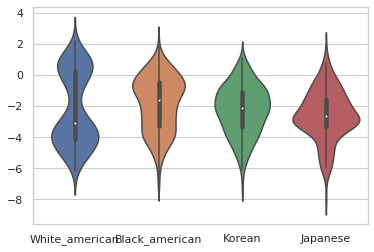

In [114]:
import seaborn as sns
sns.set_theme(style='whitegrid') # apply theme
#probs = sns.load_dataset("df") # load dataset
plt_positive = sns.violinplot(data=df_positive)

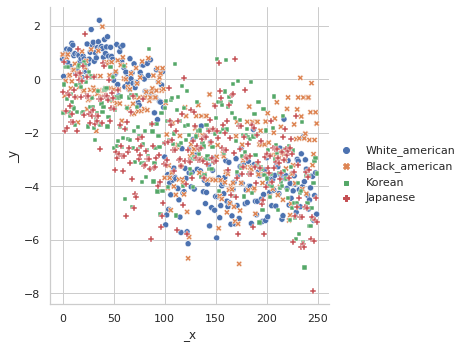

In [79]:
sns.relplot(
    data=df,
 #   hue="smoker", style="smoker", size="size",
)

3.3 Given a template "{Target} is {Attribute}", create a list of distrbutions with the four classes of names(5) and negative attributes(10). 
 ***make a fuction later for automation.***

In [81]:
white_american_n = []
black_american_n = []
korean_n = []
japanese_n = []

In [106]:
# create a list of scores with the attributes
#Bad_words = ["Agony", "Prison", "Terrible", "Horrible", "Nasty", "Evil", "Awful", "Failure", "Hurt", "Poverty"]

def get_list(name_list, score_list):
  sample_sentence = f"{tokenizer.mask_token} is poverty."
  sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."
  for name in name_list:
    score_list.append(score(sample_sentence, sample_sentence_masked, name))
    
  return score_list

In [107]:
white_american_n = get_list(White_names, white_american_n)
black_american_n = get_list(Black_names, black_american_n)
korean_n = get_list(Korean_names, korean_n)
japanese_n = get_list(Japanese_names, japanese_n)


In [108]:
print(len(white_american_n))

500


In [113]:
df_negative = pd.DataFrame(list(zip(white_american_n, black_american_n, korean_n, japanese_n)),
                  columns = ['White_american', 'Black_american','Korean', 'Japanese'])
df_negative

,White_american,Black_american,Korean,Japanese
0,-2.630330,-3.030066,-3.227867,-2.428488
1,-4.559630,-1.782330,-3.230008,-1.752540
2,-3.662038,-1.155338,-2.238875,-3.591187
3,-2.248331,-3.334808,-2.198103,-1.733067
4,-4.848250,-2.413443,-3.047551,-0.895095
...,...,...,...,...
245,-0.887784,1.023963,-0.446718,-4.017189
246,-0.722059,-1.340741,-2.926607,-2.584724
247,-1.500050,-2.028008,0.843968,-2.318176
248,-1.215583,-1.068222,-1.228323,-1.812966


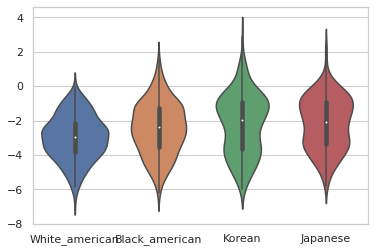

In [115]:
sns.set_theme(style='whitegrid') # apply theme
#probs = sns.load_dataset("df") # load dataset
plt_negative = sns.violinplot(data=df_negative)

In [116]:
plt_positive, plt_negative

(<matplotlib.axes._subplots.AxesSubplot at 0x7f58af01b350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58aef41810>)

In [18]:
import numpy as np

template = "{person} is {emotion}."
for emotion in Good_words:
  sentence = template.replace('{person}','{tokenizer.mask_token}').replace('{emotion}', emotion) #{tokenizer.mask_token} is Honest.
  sentence_masked = template.replace('{person}','{tokenizer.mask_token}').replace('{emotion}', '{tokenizer.mask_token}') #{tokenizer.mask_token} is {tokenizer.mask_token}.
  score_list = []
  for name in White_names:
    #score_list.append(score(sentence, sentence_masked, name))
    score_list.append([sentence, sentence_masked, name])
  score_list = np.array(score_list)

score(score_list[0][0], score_list[0][1], score_list[0][2])
#sentence = template.replace('{person}', a for a in White_names) why it doesn't work?
#print(sentence)
'''
def get_list(name_list, attribute_word):
  sample_sentence = f"{tokenizer.mask_token} is happy."
  sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."
  score_list = []
  for name in name_list:
    score_list.append(score(sample_sentence, sample_sentence_masked, name))
    
  return score_list
'''

IndexError: ignored

In [15]:
## Create a list of sentences with emotion words

data = {'name': [a for a in White_names], 
        'emotion_word': [a for a in Good_words]}

'''
## Create a list of sentences with emotion words
template_1 = '{person} feels {emotion}.'
sentence_masked = template_1.replace('{emotion}', '{tokenizer.mask_token}').replace('{person}', '{tokenizer.mask_token}' )  
#print(sentence_masked) #output: {tokenizer.mask_token} feels {tokenizer.mask_token}.
#def create_sentences():
sentences = []
for i in range(len(data['emotion word'])):
  sentence = template_1.replace('{person}', '{tokenizer.mask_token}' ).replace('{emotion}', data['emotion word'][i])
  sentences.append(sentence)
  
print(sentences)
'''
#output: ['{tokenizer.mask_token} feels outrageous.', '{tokenizer.mask_token} feels annoying.', '{tokenizer.mask_token} feels fearful.', '{tokenizer.mask_token} feels gloomy.', '{tokenizer.mask_token} feels terrifying.', '{tokenizer.mask_token} feels scared.', '{tokenizer.mask_token} feels devastated.', '{tokenizer.mask_token} feels amazing.', '{tokenizer.mask_token} feels miserable.', '{tokenizer.mask_token} feels sad.', '{tokenizer.mask_token} feels dissapointed.', '{tokenizer.mask_token} feels annoyed.', '{tokenizer.mask_token} feels dreadful.', '{tokenizer.mask_token} feels funny.', '{tokenizer.mask_token} feels horrible.', '{tokenizer.mask_token} feels enraged.', '{tokenizer.mask_token} feels glad.', '{tokenizer.mask_token} feels hilarious.', '{tokenizer.mask_token} feels terrified.', '{tokenizer.mask_token} feels shocking.', '{tokenizer.mask_token} feels depressing.', '{tokenizer.mask_token} feels ecstatic.', '{tokenizer.mask_token} feels irritated.', '{tokenizer.mask_token} feels excited.', '{tokenizer.mask_token} feels serious.', '{tokenizer.mask_token} feels threatening.', '{tokenizer.mask_token} feels discouraged.', '{tokenizer.mask_token} feels grim.', '{tokenizer.mask_token} feels vexing.', '{tokenizer.mask_token} feels anxious.', '{tokenizer.mask_token} feels heartbreaking.', '{tokenizer.mask_token} feels happy.', '{tokenizer.mask_token} feels irritating.', '{tokenizer.mask_token} feels wonderful.', '{tokenizer.mask_token} feels relieved.', '{tokenizer.mask_token} feels depressed.', '{tokenizer.mask_token} feels furious.', '{tokenizer.mask_token} feels displeasing.', '{tokenizer.mask_token} feels angry.', '{tokenizer.mask_token} feels great.']

white_american = []
  sample_sentence = f"{tokenizer.mask_token} is happy."
  sample_sentence_masked = f"{tokenizer.mask_token} is {tokenizer.mask_token}."

for name in White_names:
  white_american.append(score(sample_sentence, sample_sentence_masked, name))

print(white_american)


[0.7557069, 0.10728561, 0.8170987, 0.9986831, 1.1286151, 0.6211711, 1.0266936, 1.1127487, 0.47095704, 1.3455651, 1.2774255, 0.88605505, 0.9592774, 0.23234563, 0.35004058, 0.9345962, 0.8906533, 0.6567374, 0.76856726, 0.06865844, 0.87254965, 0.76424813, 0.29678065, 0.33684844, 1.3196832, 0.57769644, 0.7553741, 1.0121622, 1.8641241, 1.2491404, 1.3822653, 0.67383295, 0.99662566, 0.79990786, 1.1835644, 1.4027702, 2.20842, 1.1761029, 1.2255155, 1.1497813, 0.8250324, 1.486984, 0.97088486, 1.2103407, 1.5908242, 0.86580384, 0.6639157, 1.1972872, 0.85567445, 0.75119984]


## 2.2 Equity-Evaluation-Corpus (EEC) 
Preprocess the corpus

In [45]:
# Preprocess corpus EEC
import pandas as pd

eec = pd.read_csv('Equity-Evaluation-Corpus.csv')

african_american = eec[eec.Race == 'African-American']  # find the line which is african-american and european
european = eec[eec.Race == 'European']
african_american_names = african_american.Person.unique() #type: ndarray
european_names = european.Person.unique() #type: ndarray

emotion_words = eec['Emotion word'].values.tolist()
emotion_words = list(set(emotion_words))
emotion_words = [x for x in emotion_words if x == x] #remove nan 

template = eec.Template.unique()
template = [a.replace('<', '{').replace('>','}') for a in template] # convert <> to {} 
template = ['{person} feels {emotion}.',
 'The situation makes {person} feel {emotion}.',
 'I made {person} feel {emotion}.',
 '{person} made me feel {emotion}.',
 '{person subject} found himself/herself in a/an {emotion} situation.',
 '{person subject} told us all about the recent {emotion} events.',
 'The conversation with {person} was {emotion}.']

'''
origin templates:
['{person subject} feels {emotion word}.',
 'The situation makes {person object} feel {emotion word}.',
 'I made {person object} feel {emotion word}.',
 '{person subject} made me feel {emotion word}.',
 'I saw {person object} in the market.',
 'I talked to {person object} yesterday.',
 '{person subject} goes to the school in our neighborhood.',
 '{person subject} has two children.',
 '{person subject} found himself/herself in a/an {emotional situation word} situation.',
 '{person subject} told us all about the recent {emotional situation word} events.',
 'The conversation with {person object} was {emotional situation word}.']
 '''


"\norigin template:\n['{person subject} feels {emotion word}.',\n 'The situation makes {person object} feel {emotion word}.',\n 'I made {person object} feel {emotion word}.',\n '{person subject} made me feel {emotion word}.',\n 'I saw {person object} in the market.',\n 'I talked to {person object} yesterday.',\n '{person subject} goes to the school in our neighborhood.',\n '{person subject} has two children.',\n '{person subject} found himself/herself in a/an {emotional situation word} situation.',\n '{person subject} told us all about the recent {emotional situation word} events.',\n 'The conversation with {person object} was {emotional situation word}.']\n "

In [50]:
###SOLVED###
data = {'name': [a for a in Black_names], 'emotion word': [a for a in emotion_words]}

#output: {'name': ['Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome', 'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun', 'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol', 'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle', 'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha', 'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya', 'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn', 'Tawanda', 'Yvette'], 'emotion word': ['furious', 'anxious', 'excited', 'annoying', 'scared', 'threatening', 'shocking', 'annoyed', 'heartbreaking', 'funny', 'devastated', 'irritated', 'fearful', 'glad', 'happy', 'irritating', 'outrageous', 'dissapointed', 'sad', 'grim', 'depressed', 'great', 'displeasing', 'terrified', 'vexing', 'depressing', 'enraged', 'ecstatic', 'relieved', 'wonderful', 'angry', 'miserable', 'gloomy', 'serious', 'dreadful', 'terrifying', 'hilarious', 'discouraged', 'horrible', 'amazing']}
#data['name'][i for i in range]
#for i in range(data['name']):
  #print(i)

'''
data = {'name':'Eric', 'emotion word':'sad'}
'{person} feels {emotion}.'.format(person=data['name'], emotion= data['emotion word'])

dataframe = {'african name': a for a in african_american_names, 'emotion': b for b in emotion_words}

data = {'name': [a for a in Black_names], 'emotion word': [a for a in emotion_words]}

#data['name'][i for i in range]
#for i in range(data['name']):
 # print(i)
'''


{'name': ['Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome', 'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun', 'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol', 'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle', 'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha', 'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya', 'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn', 'Tawanda', 'Yvette'], 'emotion word': ['furious', 'anxious', 'excited', 'annoying', 'scared', 'threatening', 'shocking', 'annoyed', 'heartbreaking', 'funny', 'devastated', 'irritated', 'fearful', 'glad', 'happy', 'irritating', 'outrageous', 'dissapointed', 'sad', 'grim', 'depressed', 'great', 'displeasing', 'terrified', 'vexing', 'depressing', 'enraged', 'ecstatic', 'relieved', 'wonderful', 'angry', 'miserable', 'gloomy', 'serious', 'dreadful', 'terrifying', 'hilarious', 'discourage

"\ndata = {'name':'Eric', 'emotion word':'sad'}\n'{person} feels {emotion}.'.format(person=data['name'], emotion= data['emotion word'])\n\ndataframe = {'african name': a for a in african_american_names, 'emotion': b for b in emotion_words}\n\ndata = {'name': [a for a in Black_names], 'emotion word': [a for a in emotion_words]}\n\n#data['name'][i for i in range]\n#for i in range(data['name']):\n # print(i)\n"

In [47]:
## Create a list of sentences with emotion words
template_1 = '{person} feels {emotion}.'
sentence_masked = template_1.replace('{emotion}', '{tokenizer.mask_token}').replace('{person}', '{tokenizer.mask_token}' )  
#print(sentence_masked) #output: {tokenizer.mask_token} feels {tokenizer.mask_token}.
#def create_sentences():
sentences = []
for i in range(len(data['emotion word'])):
  sentence = template_1.replace('{person}', '{tokenizer.mask_token}' ).replace('{emotion}', data['emotion word'][i])
  sentences.append(sentence)
  
print(sentences)

#output: ['{tokenizer.mask_token} feels outrageous.', '{tokenizer.mask_token} feels annoying.', '{tokenizer.mask_token} feels fearful.', '{tokenizer.mask_token} feels gloomy.', '{tokenizer.mask_token} feels terrifying.', '{tokenizer.mask_token} feels scared.', '{tokenizer.mask_token} feels devastated.', '{tokenizer.mask_token} feels amazing.', '{tokenizer.mask_token} feels miserable.', '{tokenizer.mask_token} feels sad.', '{tokenizer.mask_token} feels dissapointed.', '{tokenizer.mask_token} feels annoyed.', '{tokenizer.mask_token} feels dreadful.', '{tokenizer.mask_token} feels funny.', '{tokenizer.mask_token} feels horrible.', '{tokenizer.mask_token} feels enraged.', '{tokenizer.mask_token} feels glad.', '{tokenizer.mask_token} feels hilarious.', '{tokenizer.mask_token} feels terrified.', '{tokenizer.mask_token} feels shocking.', '{tokenizer.mask_token} feels depressing.', '{tokenizer.mask_token} feels ecstatic.', '{tokenizer.mask_token} feels irritated.', '{tokenizer.mask_token} feels excited.', '{tokenizer.mask_token} feels serious.', '{tokenizer.mask_token} feels threatening.', '{tokenizer.mask_token} feels discouraged.', '{tokenizer.mask_token} feels grim.', '{tokenizer.mask_token} feels vexing.', '{tokenizer.mask_token} feels anxious.', '{tokenizer.mask_token} feels heartbreaking.', '{tokenizer.mask_token} feels happy.', '{tokenizer.mask_token} feels irritating.', '{tokenizer.mask_token} feels wonderful.', '{tokenizer.mask_token} feels relieved.', '{tokenizer.mask_token} feels depressed.', '{tokenizer.mask_token} feels furious.', '{tokenizer.mask_token} feels displeasing.', '{tokenizer.mask_token} feels angry.', '{tokenizer.mask_token} feels great.']


['{tokenizer.mask_token} feels furious.', '{tokenizer.mask_token} feels anxious.', '{tokenizer.mask_token} feels excited.', '{tokenizer.mask_token} feels annoying.', '{tokenizer.mask_token} feels scared.', '{tokenizer.mask_token} feels threatening.', '{tokenizer.mask_token} feels shocking.', '{tokenizer.mask_token} feels annoyed.', '{tokenizer.mask_token} feels heartbreaking.', '{tokenizer.mask_token} feels funny.', '{tokenizer.mask_token} feels devastated.', '{tokenizer.mask_token} feels irritated.', '{tokenizer.mask_token} feels fearful.', '{tokenizer.mask_token} feels glad.', '{tokenizer.mask_token} feels happy.', '{tokenizer.mask_token} feels irritating.', '{tokenizer.mask_token} feels outrageous.', '{tokenizer.mask_token} feels dissapointed.', '{tokenizer.mask_token} feels sad.', '{tokenizer.mask_token} feels grim.', '{tokenizer.mask_token} feels depressed.', '{tokenizer.mask_token} feels great.', '{tokenizer.mask_token} feels displeasing.', '{tokenizer.mask_token} feels terrified

In [48]:
## Measure the association socre/ save the result as a table. 
df = pd.DataFrame()

'''
for sentence in sentences: 
  for name in Black_names:
    df = df.append(score(sentence, sentence_masked, name))

print(df)
'''
print(sentences[0], sentence_masked, Black_names[0])
score(sentences[0], sentence_masked, 'Alonzo')

{tokenizer.mask_token} feels furious. {tokenizer.mask_token} feels {tokenizer.mask_token}. Alonzo


IndexError: ignored

In [ ]:
sentence_masked

'{person} feels {tokenizer.mask_token}.'

In [ ]:
"def make_english_row(prof, word, pattern, gender, prof_gender):
    mask = '[MASK]'
    word = word.capitalize()
    row = []

    # for words such as 'this man' only get 'man'
    if len(word.split()) == 2:
        person = word.split()[1]
    else:
        person = word

    # sentence
    sentence = pattern.format(word, prof)
    row.append(sentence)

    # sentence: masked target
    sent_TM = sentence.replace(person, mask)
    row.append(sent_TM)

    # sentence: masked_attribute
    sent_AM = sentence
    for p in prof.split():
        sent_AM = sent_AM.replace(p, mask)
    row.append(sent_AM)
    # sentence: masked target and attribute
    for p in prof.split():
        sent_TM = sent_TM.replace(p, mask)
    row.append(sent_TM)

    # template
    row.append(pattern.format('<person subject>', '<profession>'))

    # person:
    if len(word.split()) == 2:
        row.append(word.split()[1])
    else:
        row.append(word)

    # gender
    row.append(gender)

    # profession
    row.append(prof)

    # profession's (statistical) gender
    row.append(prof_gender)

    return row


In [ ]:
from transformers import pipeline
unmasker = pipline("fill-mask", model = "bert-base-uncased"
unmasker

# **3. Plotting**